# Narrative GMM Turning Points (銀河鉄道 × 不確実性 × GMM)

このノートブックは、物語JSON（イベント + 原文引用付き）から **(m=Morality, iso=Isolation)** の2次元点列を取り出し、
半教師ありGMM（EM）で

- 状態クラスタ（意味付き）
- 境界点Top20（揺れ：不確実性が高い点）
- 章ごとの転調密度（turning density）
- クラスタ遷移（状態切替）

を **図＋CSV** として出力します。

## Outputs（`outputs/`）
- `events_all.csv`
- `preds_all.csv`
- `cluster_name_map.csv`
- `boundary_top20.csv`
- `boundary_context.csv`
- `scene_turning_density.csv`
- `scene_cluster_transitions.csv`
- `cluster_transition_points.csv`
- `gmm_params.npz`


In [1]:
# ===== Setup (Colab) =====
import os, sys, glob
from pathlib import Path

REPO_URL = "https://github.com/Mokafe/ginga-narrative-gmm.git"
REPO_DIR = Path("/content/ginga-narrative-gmm")

# 1) clone (初回だけ)
if not REPO_DIR.exists():
    !git clone --depth 1 {REPO_URL} {REPO_DIR}

# 2) 作業ディレクトリを repo に
%cd {REPO_DIR}

# 3) パス確認（src を import できるように）
sys.path.append(str(REPO_DIR / "src"))

print("cwd:", os.getcwd())
print("repo files:", [p.name for p in REPO_DIR.iterdir()][:20])
print("notebooks:", glob.glob(str(REPO_DIR/"notebooks/*.ipynb")))


Cloning into '/content/ginga-narrative-gmm'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 681.17 KiB | 11.35 MiB/s, done.
/content/ginga-narrative-gmm
cwd: /content/ginga-narrative-gmm
repo files: ['requirements.txt', 'data', 'scripts', '.git', 'README.md', 'notebooks', 'src', 'assets', 'LICENSE', 'docs']
notebooks: ['/content/ginga-narrative-gmm/notebooks/00_green_ticket_algorithm_original.ipynb', '/content/ginga-narrative-gmm/notebooks/00_narrative_gmm_turning_points.ipynb']


In [2]:
# ===== Data (JSON) =====
from pathlib import Path
import os, glob

# どこに置いても拾う（/content でも repo/data でも Drive でも）
CANDIDATES = [
    "/content/sample_g_1_reconstructed_keep_last9.json",
    str(Path("/content/ginga-narrative-gmm/data/sample/sample_g_1_reconstructed_keep_last9.json")),
    str(Path("/content/ginga-narrative-gmm") / "sample_g_1_reconstructed_keep_last9.json"),
]

found = None
for p in CANDIDATES:
    if Path(p).exists():
        found = p
        break

if found is None:
    # /content 配下を探索（アップロードした場合ここで拾える）
    hits = glob.glob("/content/**/*.json", recursive=True)
    if hits:
        found = hits[0]

if found is None:
    raise FileNotFoundError(
        "JSONが見つかりません。左のFilesから sample_g_1_reconstructed_keep_last9.json をアップロードしてください。"
    )

JSON_PATH = found
print("Using JSON_PATH:", JSON_PATH)


Using JSON_PATH: /content/ginga-narrative-gmm/data/sample/sample_g_1_reconstructed_keep_last9.json


In [3]:
# ===== 0) Setup =====
# (Colab) 初回だけ必要なら実行：
# !pip -q install -r requirements.txt

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# repoルートで実行する想定：src を import path に追加
ROOT = Path.cwd()
if (ROOT / "src").exists():
    sys.path.insert(0, str(ROOT / "src"))

from narrative_gmm.io_json import load_events_df
from narrative_gmm.gmm_semisup import fit_gmm_semisup
from narrative_gmm.metrics import add_posteriors, boundary_topN, boundary_context
from narrative_gmm.report import auto_name_clusters, compute_scene_turning_density, compute_scene_transitions, compute_global_transition_points
from narrative_gmm import plot as plot_mod

JSON_PATH = "data/sample/sample_g_1_reconstructed_keep_last9.json"
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = ["m", "iso"]
K = 2
ALPHA = 20.0
REG = 1e-3
DIAG_COV = True

# 再現性（教材向け）：固定すると毎回ほぼ同じ境界Top20になります
SEED = 229
N_INIT = 50
MAX_ITER = 400
TOL = 1e-4

TOP_N_BOUNDARY = 20
CONTEXT_W = 2
print("JSON_PATH:", JSON_PATH)


JSON_PATH: data/sample/sample_g_1_reconstructed_keep_last9.json


In [4]:
# ===== 1) Load JSON -> DataFrame =====
# 物語（イベント/引用）を保持したまま、数値特徴(m, iso)を取り出して表にします。
df = load_events_df(JSON_PATH)
df.to_csv(OUT_DIR/"events_all.csv", index=False, encoding="utf-8-sig")
df.head(5)


,chapter_title,scene_id,global_step,local_step,local_time,event,desc,evidence_1,evidence_2,m,iso,t,status,label,global_time
0,一、午后（ごご）の授業,1_gogo_class,1,1,0.0,手を上げかけて引っ込める（自信の揺れ）,答えは知っている記憶があるが、自己評価の不安で行動を抑える。,手をあげようとして、急いでやめました,いつか雑誌で読んだのでしたが,0.50,0.55,0.0,unlabeled,-1,0.000000
1,一、午后（ごご）の授業,1_gogo_class,2,2,0.2,疲労と欠乏で『わからない』感覚が増す,眠気と学習資源の欠乏が継続し、理解の手応えが失われる。,毎日教室でもねむく,どんなこともよくわからない,0.50,0.65,0.2,unlabeled,-1,0.010309
2,一、午后（ごご）の授業,1_gogo_class,3,3,0.4,先生に見つかり指名される（公的圧力）,注目が集まり、失敗への恐れが自己防衛を強める。,先生は早くもそれを見附けた,あなたはわかっているのでしょう,0.45,0.70,0.4,unlabeled,-1,0.020619
3,一、午后（ごご）の授業,1_gogo_class,4,4,0.6,立つが答えられない（無力感の顕在化）,意気込んで立つが言葉が出ず、自己評価の低下が進む。,勢よく立ちあがりましたが,答えることができないのでした,0.40,0.72,0.6,unlabeled,-1,0.030928
4,一、午后（ごご）の授業,1_gogo_class,5,5,0.8,嘲笑と赤面（自己防衛への退避）,他者の視線と笑いが羞恥を増幅し、関係から退きたくなる状態に傾く。,くすっとわらいました,どぎまぎしてまっ赤になって,0.25,0.80,0.8,labeled,1,0.041237


In [5]:
# ===== 2) Fit semi-supervised GMM (EM) =====
# labeled点（アンカー）を alpha 倍の強さで混ぜて、クラスタの「意味」を安定化します。
X_all = df[FEATURES].to_numpy()
mask_l = df["label"].to_numpy() >= 0
X_l = X_all[mask_l]
y_l = df.loc[mask_l, "label"].to_numpy().astype(int)
X_u = X_all[~mask_l]

ss = fit_gmm_semisup(
    X_u, X_l, y_l,
    K=K, alpha=ALPHA, reg=REG, diag=DIAG_COV,
    seed=SEED, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL
)

np.savez(OUT_DIR/"gmm_params.npz", phi=ss["phi"], mu=ss["mu"], Sigma=ss["Sigma"])
print("fitted:", {k: (v.shape if hasattr(v,'shape') else v) for k,v in ss.items() if k!='it'}, "it=", ss["it"])


fitted: {'phi': (2,), 'mu': (2, 2), 'Sigma': (2, 2, 2)} it= 28


In [6]:
# ===== Table 2) K comparison (BIC/AIC/Silhouette + anchor alignment) =====
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def fit_gmm_sklearn(X, K, seed):
    cov_type = "diag" if DIAG_COV else "full"
    gmm = GaussianMixture(
        n_components=K,
        covariance_type=cov_type,
        reg_covar=REG,
        n_init=N_INIT,
        max_iter=MAX_ITER,
        tol=TOL,
        random_state=seed,
    )
    gmm.fit(X)
    return gmm

def anchor_majority_accuracy(cluster_ids, y_true):
    """Kが2以上でもOK：各クラスタをアンカーの多数決で 0/1 に割り当て、アンカー上の精度を返す"""
    if len(y_true) == 0:
        return np.nan

    mapping = {}
    for c in np.unique(cluster_ids):
        ys = y_true[cluster_ids == c]
        if len(ys) == 0:
            continue
        vals, cnt = np.unique(ys, return_counts=True)
        mapping[c] = int(vals[np.argmax(cnt)])

    y_pred = np.array([mapping.get(c, -1) for c in cluster_ids], dtype=int)
    return (y_pred == y_true).mean()

K_CANDIDATES = [1,2,3,4,5,6]  # 必要なら増やす
rows = []

for k in K_CANDIDATES:
    gmm = fit_gmm_sklearn(X_all, k, SEED)
    z = gmm.predict(X_all)

    # silhouette は K>=2 & 2クラスタ以上成立時のみ
    sil = np.nan
    if k >= 2 and len(np.unique(z)) >= 2:
        sil = float(silhouette_score(X_all, z))

    aic = float(gmm.aic(X_all))
    bic = float(gmm.bic(X_all))

    # アンカー整合（アンカー点のみで多数決精度）
    acc = np.nan
    if len(X_l) > 0:
        z_l = gmm.predict(X_l)
        acc = float(anchor_majority_accuracy(z_l, y_l))

    rows.append({
        "K": k,
        "BIC (lower better)": bic,
        "AIC (lower better)": aic,
        "Silhouette (higher better)": sil,
        "Anchor agreement (maj.vote)": acc,
        "Converged": bool(getattr(gmm, "converged_", True)),
        "n_iter": int(getattr(gmm, "n_iter_", -1)),
    })

table2 = pd.DataFrame(rows).sort_values("BIC (lower better)").reset_index(drop=True)
table2.to_csv(OUT_DIR / "table2_K_comparison.csv", index=False, encoding="utf-8-sig")
table2


,K,BIC (lower better),AIC (lower better),Silhouette (higher better),Anchor agreement (maj.vote),Converged,n_iter
0,2,-197.834997,-221.099705,0.410386,0.857143,True,66
1,1,-197.660390,-208.000260,NaN,0.714286,True,2
2,3,-182.828083,-219.017627,0.362225,1.000000,True,14
3,4,-175.279388,-224.393770,0.245848,0.857143,True,44
4,5,-156.319921,-218.359141,0.362089,1.000000,True,46
5,6,-140.541032,-215.505089,0.382620,1.000000,True,16


In [7]:
# ===== Table 3) alpha comparison (unsupervised alpha=0 vs semi-supervised) =====
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.mixture import GaussianMixture

def to_full_sigma_from_sklearn(gmm):
    """sklearn GMMのcovariances_を (K,D,D) に整形"""
    if gmm.covariance_type == "diag":
        return np.stack([np.diag(c) for c in gmm.covariances_], axis=0)
    elif gmm.covariance_type == "full":
        return gmm.covariances_
    else:
        raise ValueError("Unsupported covariance_type:", gmm.covariance_type)

def run_model(alpha, seed):
    """alpha=0: 純教師なし(sklearn GMM)。alpha>0: 既存の半教師ありEM(fit_gmm_semisup)"""
    if alpha == 0:
        cov_type = "diag" if DIAG_COV else "full"
        gmm = GaussianMixture(
            n_components=K,
            covariance_type=cov_type,
            reg_covar=REG,
            n_init=N_INIT,
            max_iter=MAX_ITER,
            tol=TOL,
            random_state=seed,
        ).fit(X_all)
        phi, mu, Sigma = gmm.weights_, gmm.means_, to_full_sigma_from_sklearn(gmm)
    else:
        ss = fit_gmm_semisup(
            X_u, X_l, y_l,
            K=K, alpha=alpha, reg=REG, diag=DIAG_COV,
            seed=seed, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL
        )
        phi, mu, Sigma = ss["phi"], ss["mu"], ss["Sigma"]

    preds, _ = add_posteriors(df, X_all, phi, mu, Sigma)
    preds, _ = auto_name_clusters(preds, K=K)  # 0/1の意味をアンカー側に寄せる（既存手順）:contentReference[oaicite:4]{index=4}
    boundary = boundary_topN(preds, top_n=TOP_N_BOUNDARY)

    boundary_steps = set(boundary["global_step"].astype(int).tolist())
    return preds, boundary_steps

def anchor_acc(preds):
    """アンカー点（label>=0）に対する精度"""
    m = preds["label"].to_numpy() >= 0
    if m.sum() == 0:
        return np.nan
    y_true = preds.loc[m, "label"].to_numpy().astype(int)
    z = preds.loc[m, "cluster"].to_numpy().astype(int)

    # ここではK=2前提で、反転のうち良い方を採用（厳密でシンプル）
    acc0 = (z == y_true).mean()
    acc1 = ((1 - z) == y_true).mean()
    return float(max(acc0, acc1))

def n_transitions(preds):
    """global_step順にクラスタが切り替わった回数（=物語上の状態遷移の多さ）"""
    s = preds.sort_values("global_step")["cluster"].to_numpy()
    return int(np.sum(s[1:] != s[:-1]))

def jaccard(a, b):
    a, b = set(a), set(b)
    if len(a | b) == 0:
        return 1.0
    return len(a & b) / len(a | b)

def mean_pairwise_jaccard(list_of_sets):
    pairs = list(combinations(list_of_sets, 2))
    if len(pairs) == 0:
        return np.nan
    return float(np.mean([jaccard(x, y) for x, y in pairs]))

ALPHAS = [0, 1, 5, 10, 20, 50]  # 比較したいalpha
SEEDS  = [0, 1, 2, 3, 4]        # 安定性を見るため複数seed（増やすほど強いが時間は増える）

# まずalpha=0の境界（seedごと）を保持（後でoverlap比較に使う）
baseline_boundary = {}
baseline_metrics  = {}

for sd in SEEDS:
    preds0, b0 = run_model(alpha=0, seed=sd)
    baseline_boundary[sd] = b0
    baseline_metrics[sd] = {
        "anchor_acc": anchor_acc(preds0),
        "n_transitions": n_transitions(preds0),
        "entropy_sum": float(preds0["entropy"].sum()),
    }

rows = []
for a in ALPHAS:
    boundaries = []
    accs, trans, esums, overlap0 = [], [], [], []

    for sd in SEEDS:
        predsA, bA = run_model(alpha=a, seed=sd)
        boundaries.append(bA)

        accs.append(anchor_acc(predsA))
        trans.append(n_transitions(predsA))
        esums.append(float(predsA["entropy"].sum()))

        # alpha=0（同seed）との境界TopNの重なり
        overlap0.append(jaccard(bA, baseline_boundary[sd]))

    rows.append({
        "alpha": a,
        "anchor_acc_mean": float(np.mean(accs)),
        "anchor_acc_sd": float(np.std(accs)),
        "boundary_stability_Jaccard_within": mean_pairwise_jaccard(boundaries),
        "boundary_overlap_vs_alpha0_mean": float(np.mean(overlap0)),
        "n_transitions_mean": float(np.mean(trans)),
        "entropy_sum_mean": float(np.mean(esums)),
        "seeds": len(SEEDS),
    })

table3 = pd.DataFrame(rows)
table3.to_csv(OUT_DIR / "table3_alpha_comparison.csv", index=False, encoding="utf-8-sig")
table3

,alpha,anchor_acc_mean,anchor_acc_sd,boundary_stability_Jaccard_within,boundary_overlap_vs_alpha0_mean,n_transitions_mean,entropy_sum_mean,seeds
0,0,0.857143,0.0,1.00,1.000000,14.0,4.243918,5
1,1,1.000000,0.0,0.76,0.494505,20.4,16.665083,5
2,5,1.000000,0.0,1.00,0.904762,12.0,3.694032,5
3,10,1.000000,0.0,1.00,0.904762,12.0,3.151913,5
4,20,1.000000,0.0,1.00,0.818182,12.0,3.199354,5
5,50,1.000000,0.0,1.00,0.666667,16.0,3.470411,5


In [8]:
# ===== 3) Predict + boundary extraction =====
# posterior（所属確率）から、entropy / margin を作り「揺れ」を抽出します。
preds, w_all = add_posteriors(df, X_all, ss["phi"], ss["mu"], ss["Sigma"])

# (重要) 0/1 のクラスタ番号を、人間のラベル(Communal vs Self_Protection)に寄せて自動命名
preds, name_map = auto_name_clusters(preds, K=K)
name_map.to_csv(OUT_DIR/"cluster_name_map.csv", index=False, encoding="utf-8-sig")

preds.to_csv(OUT_DIR/"preds_all.csv", index=False, encoding="utf-8-sig")

boundary = boundary_topN(preds, top_n=TOP_N_BOUNDARY)
boundary.to_csv(OUT_DIR/"boundary_top20.csv", index=False, encoding="utf-8-sig")

ctx = boundary_context(preds, boundary, context_w=CONTEXT_W)
ctx.to_csv(OUT_DIR/"boundary_context.csv", index=False, encoding="utf-8-sig")

name_map


,cluster,cluster_name,name_confidence
0,0,Communal_Happiness,0.970185
1,1,Self_Protection,1.000000


In [9]:
# ===== 4) Chapter summaries (転調密度 / 遷移) =====
boundary_steps = set(boundary["global_step"].astype(int).tolist())

scene_density = compute_scene_turning_density(preds, boundary_steps)
scene_density.to_csv(OUT_DIR/"scene_turning_density.csv", index=False, encoding="utf-8-sig")

scene_transitions = compute_scene_transitions(preds)
scene_transitions.to_csv(OUT_DIR/"scene_cluster_transitions.csv", index=False, encoding="utf-8-sig")

transition_points = compute_global_transition_points(preds)
transition_points.to_csv(OUT_DIR/"cluster_transition_points.csv", index=False, encoding="utf-8-sig")

scene_density.head(10)


,scene_id,chapter_title,n_events,n_boundary_topN,boundary_topN_ratio,entropy_sum,entropy_mean,entropy_max,uncertainty_mean,peak_global_step,peak_local_step,peak_event,peak_evidence_1,m,iso,cluster,p_max,margin,entropy
4,5_weather_pillar,五、天気輪（てんきりん）の柱,8,5,0.625000,7.605152e-01,9.506440e-02,6.590113e-01,4.824645e-02,39,7,列車と旅人を想像して悲しみが強まる（推測）,汽車の音が聞えてきました,0.40,0.80,0,0.629895,0.259791,6.590113e-01
3,4_festival_night,四、ケンタウル祭の夜,10,4,0.400000,6.684115e-01,6.684115e-02,3.547457e-01,1.926802e-02,23,1,さびしい口付きで坂を下りる,さびしい口付きで,0.40,0.70,0,0.886025,0.772050,3.547457e-01
2,3_home,三、家,10,1,0.100000,6.590270e-01,6.590270e-02,6.590113e-01,3.701056e-02,20,8,『ラッコの上着』をからかわれていると語る,みんながぼくにあうとそれを云う,0.40,0.80,0,0.629895,0.259791,6.590113e-01
0,1_gogo_class,一、午后（ごご）の授業,6,3,0.500000,4.558475e-01,7.597458e-02,4.220104e-01,2.573503e-02,4,4,立つが答えられない（無力感の顕在化）,勢よく立ちあがりましたが,0.40,0.72,0,0.850402,0.700805,4.220104e-01
1,2_printshop,二、活版所,6,3,0.500000,3.898740e-01,6.497901e-02,3.547457e-01,1.982596e-02,11,5,目を拭いながら作業を続ける,何べんも眼を拭いながら,0.40,0.70,0,0.886025,0.772050,3.547457e-01
8,9_ticket,九、ジョバンニの切符（きっぷ）,31,3,0.096774,2.542206e-01,8.200664e-03,1.992127e-01,1.894310e-03,78,11,苹果を勧められ呼ばれ方に反発する,こういう苹果（りんご）はおはじめて,0.20,0.60,1,0.949763,0.899526,1.992127e-01
7,8_bird_catcher,八、鳥を捕（と）る人,10,1,0.100000,1.122219e-02,1.122219e-03,7.510567e-03,1.360839e-04,59,2,控えめに挨拶し、さびしさを覚える,少し肩をすぼめて挨拶しました,0.45,0.65,0,0.999057,0.998114,7.510567e-03
5,6_galaxy_station,六、銀河ステーション,8,0,0.000000,2.344463e-04,2.930579e-05,1.581994e-04,2.340941e-06,41,1,天気輪の柱が標識のように変わって見える,三角標の形になって,0.50,0.70,0,0.999987,0.999974,1.581994e-04
6,7_cross_priosin,七、北十字とプリオシン海岸,9,0,0.000000,1.245291e-10,1.383657e-11,1.322547e-10,5.526197e-13,57,9,無人の改札と広場へ出る,誰も居ませんでした,0.60,0.60,0,1.000000,1.000000,1.322547e-10


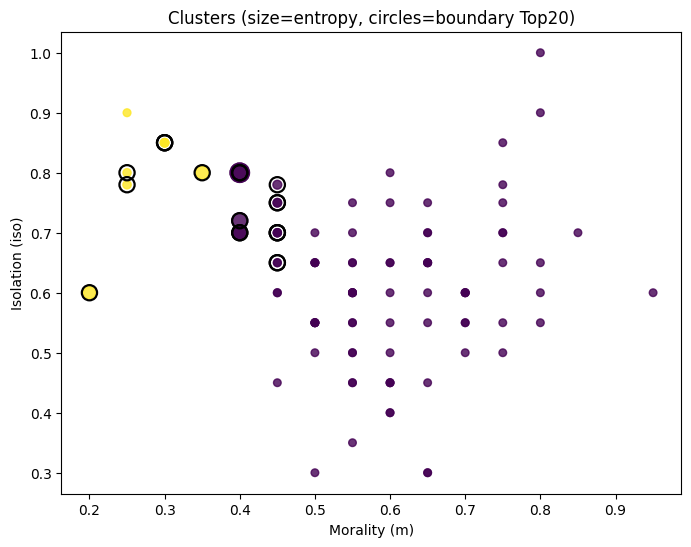

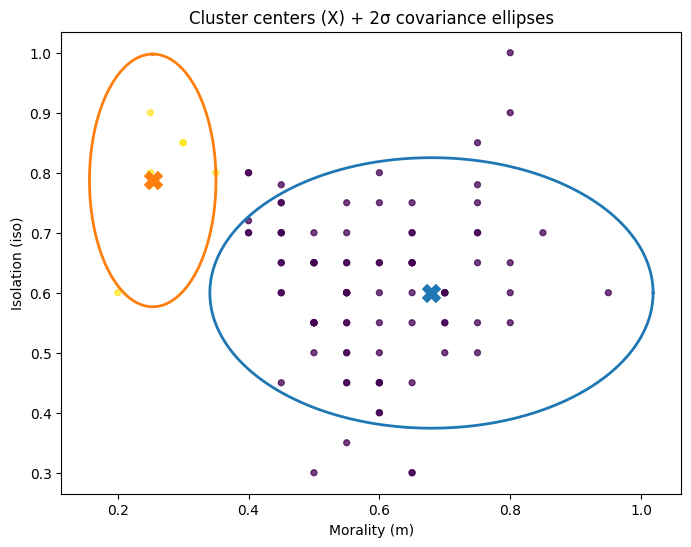

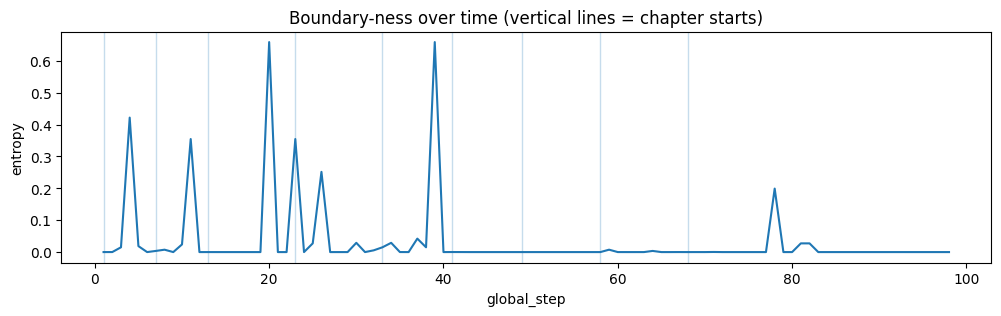

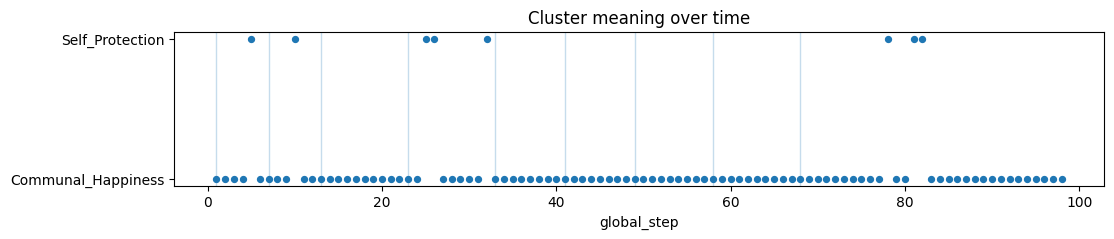

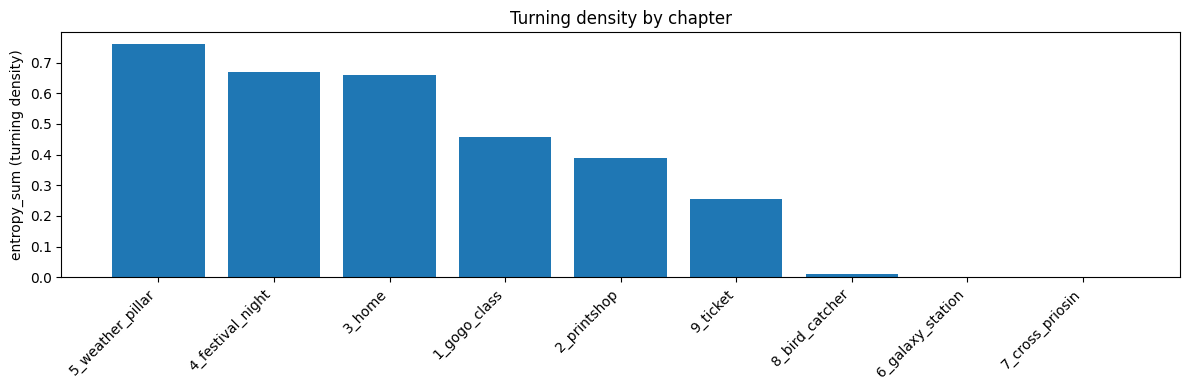

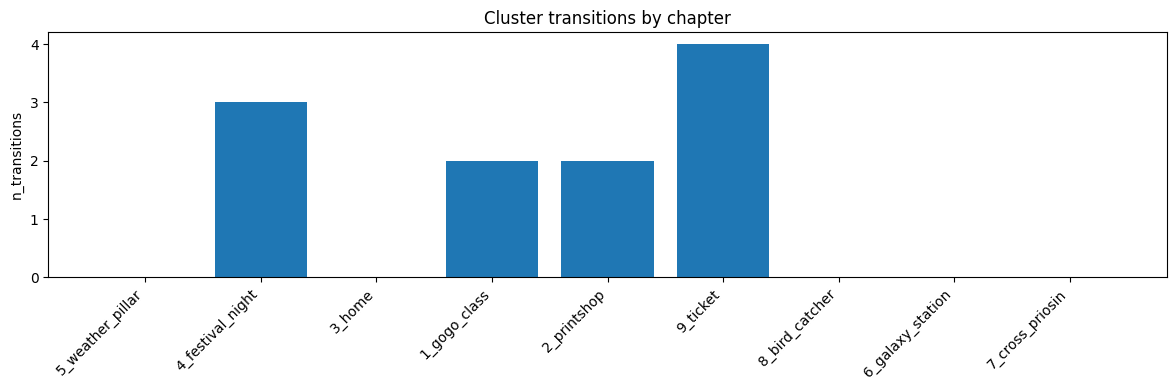

,global_step,scene_id,chapter_title,m,iso,cluster_name,p_max,margin,entropy,event,evidence_1,evidence_2
19,20,3_home,三、家,0.40,0.80,Communal_Happiness,0.629895,0.259791,0.659011,『ラッコの上着』をからかわれていると語る,みんながぼくにあうとそれを云う,ひやかすように云うんだ
38,39,5_weather_pillar,五、天気輪（てんきりん）の柱,0.40,0.80,Communal_Happiness,0.629895,0.259791,0.659011,列車と旅人を想像して悲しみが強まる（推測）,汽車の音が聞えてきました,かなしくなって
3,4,1_gogo_class,一、午后（ごご）の授業,0.40,0.72,Communal_Happiness,0.850402,0.700805,0.422010,立つが答えられない（無力感の顕在化）,勢よく立ちあがりましたが,答えることができないのでした
10,11,2_printshop,二、活版所,0.40,0.70,Communal_Happiness,0.886025,0.772050,0.354746,目を拭いながら作業を続ける,何べんも眼を拭いながら,だんだんひろいました
22,23,4_festival_night,四、ケンタウル祭の夜,0.40,0.70,Communal_Happiness,0.886025,0.772050,0.354746,さびしい口付きで坂を下りる,さびしい口付きで,町の坂を下りて来た
25,26,4_festival_night,四、ケンタウル祭の夜,0.35,0.80,Self_Protection,0.930735,0.861469,0.251734,怒って叫び返し、理由を考える,高く叫び返しました,せわしくいろいろのことを考え
77,78,9_ticket,九、ジョバンニの切符（きっぷ）,0.20,0.60,Self_Protection,0.949763,0.899526,0.199213,苹果を勧められ呼ばれ方に反発する,こういう苹果（りんご）はおはじめて,すこししゃくにさわってだまっていました
36,37,5_weather_pillar,五、天気輪（てんきりん）の柱,0.45,0.78,Communal_Happiness,0.992887,0.985773,0.042269,草に身を投げる（疲労の顕在化）,どかどかするからだ,つめたい草に投げました
29,30,4_festival_night,四、ケンタウル祭の夜,0.45,0.75,Communal_Happiness,0.995455,0.990910,0.029049,祝祭の中で首を垂れ、別のことを考える,深く首を垂れて,まるでちがったことを考え
33,34,5_weather_pillar,五、天気輪（てんきりん）の柱,0.45,0.75,Communal_Happiness,0.995455,0.990910,0.029049,露の林道をどんどん登る,どんどんのぼって行きました,星あかりに照らしだされて


In [10]:
# ===== 5) Plots (decision regions なしで読みやすく) =====
plot_mod.scatter_entropy(preds, boundary, title="Clusters (size=entropy, circles=boundary Top20)")
plot_mod.centers_ellipses(preds, ss["mu"], ss["Sigma"])
plot_mod.time_series_entropy_and_clusters(preds, use_cluster_name=True)
plot_mod.chapter_bars(scene_density, scene_transitions)

# 境界Top20（本文へ還元しやすい表示）
show_cols = ["global_step","scene_id","chapter_title","m","iso","cluster_name","p_max","margin","entropy","event","evidence_1","evidence_2"]
boundary[show_cols]


## メモ：SEEDについて
- `SEED` を固定すると、初期化が同じになり **教材として再現可能** になります。
- `SEED=None` にすると、探索的に毎回違う結果が出ます（その代わり `N_INIT` を増やすと安定します）。
